#Analysis and Visualization of Results
This notebook includes the necessary code to:
* Load pre-saved and processed data from data preparation notebook
* Create dataset wide visualizations for presentation or report
* Query the extracted data by year, product, reason, state
* Visualize queried results of recalls
* Run interactive query and visualization tool at the bottom



In [4]:
!pip install kaleido
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
import requests
from bs4 import BeautifulSoup as bs
import pickle
import sys
from collections import defaultdict
import plotly.express as px
import kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.1 MB/s 


In [49]:
drive.mount("/content/drive") #mount google drive to load data
augmented_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/augmented_dataset.csv") #load data from csv to dataframe
#can similarly load data from local csv file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Overall Dataset

In [6]:
recalls = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/recalls.csv")
locs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/locations.csv", squeeze=True)
#load in tabular recalls data and locations text data
#can use .csv or .dat files
#can use local directory

In [7]:
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}
#dict of state abbrev and name              
#from web resource list of state names

In [9]:
#get the total count of recalls listed affecting each state
state_counts = defaultdict(int)
for s in states.values():
  for r in recalls.states:
    if type(r)==float: #if np.nan type float then ignore (no data available)
      continue
    elif s in r:
      state_counts[s]+=1

In [10]:
#plot overall choropleth of states and their recall counts, with count and color scale on right
fig = px.choropleth(locations=list(states.keys()), locationmode="USA-states", color=list(state_counts.values()), scope="usa", 
                    title="Choropleth of Listed Recalls per US State (Jan 2010 to Oct 2022)")
fig.show()
#fig.write_image("/content/drive/MyDrive/Colab Notebooks/overall_state_choropleth.jpeg")

#in notebook preview, please hover over the state to view state abbreviation and recall count/color
#scroll to zoom; drag to move; double click to reset zoom

#Data Preparation

In [50]:
#configure some column names, prepare data for analysis
col = augmented_df.columns
augmented_df.drop(col[0], axis=1, inplace=True)
augmented_df.rename(columns={'0': 'products', '0.1': 'reasons'}, inplace=True)

In [51]:
augmented_df.columns

Index(['start_date', 'end_date', 'risk_level', 'quantity_recovered', 'url',
       'states', 'products', 'reasons'],
      dtype='object')

In [52]:
augmented_df.head()

,start_date,end_date,risk_level,quantity_recovered,url,states,products,reasons
0,2010-01-09,2012-06-03,High,117.0,https://www.fsis.usda.gov/recalls-alerts/calif...,California,pork skin products,mislabeling and an undeclared allergen
1,2010-01-11,2013-06-03,High,1391.0,https://www.fsis.usda.gov/recalls-alerts/massa...,Massachusetts,beef products,possible e. coli o157:h7 contamination
2,2010-01-15,2013-06-03,Low,218.0,https://www.fsis.usda.gov/recalls-alerts/new-y...,New York,beef carcass,contains prohibited materials
3,2010-01-18,2013-06-03,High,277604.0,https://www.fsis.usda.gov/recalls-alerts/calif...,California,beef products,possible e. coli o157:h7 contamination
4,2010-01-20,2013-06-03,High,4800.0,https://www.fsis.usda.gov/recalls-alerts/india...,"Delaware, Florida, Illinois, Indiana, Iowa, Ke...",frozen chicken pot pie products,may contain foreign materials


In [53]:
#convert dates to datetime
augmented_df["start_date"] = pd.to_datetime(augmented_df["start_date"])
augmented_df["end_date"] = pd.to_datetime(augmented_df["end_date"])

#Visualizations

##Functions

In [15]:
def pie_q(df_sub, title):
  #pie chart of recall risk level per subset
  #take input fully subset data and title

  values = pd.value_counts(df_sub["risk_level"])
  labels = list(values.index)
  for i in range(len(labels)):
    labels[i] += " ("+str(values[i])+")"

  plt.pie(values, labels=labels, autopct='%.1f%%')
  plt.title(title)
  plt.legend();

In [16]:
def line_q(df_sub, title):
  #line plot of recalls per year based on start date
  #take input fully subset data and title
  #only for all years

  start_groups = df_sub["start_date"].groupby(df_sub.start_date.dt.year).value_counts().sum(level=0)

  start_groups.plot.line(ylabel="count", xlabel="start date year", rot="45", title=title);
  #[(d, start_groups[d]) for d in start_groups.index]

In [23]:
def bar_q(df_sub, title, qtype):
  #bar graph of recalls per common products or reasons
  #type p for product query or r for reason query
  #take input fully subset data and title

  labels = []
  values = []

  if qtype == "p": #if product query then labels are reasons
    labels = ["allergen", "contamination", "listeria", "e. coli", "misbranding", "inspection"]
    for label in labels:
      labelled = df_sub[df_sub.reasons.str.contains(label, na=False)]
      values.append(len(labelled))
  else: #if reason query then labels are products
    labels = ["beef", "pork", "chicken", "fish", "frozen", "bread", "ready-to-eat", "salad"]
    for label in labels:
      labelled = df_sub[df_sub.products.str.contains(label, na=False)]
      values.append(len(labelled))

  for i in range(len(labels)):
    labels[i] += " ("+str(values[i])+")"

  plt.xticks(rotation=40, ha="right")
  plt.bar(labels, values)
  plt.title(title);

In [87]:
def map_q(df_sub, title):
  #choropleth or map plot of recalls per state
  #take input fully subset data and title
  #only for all states

  #get the total count of recalls listed affecting each state
  state_counts = defaultdict(int)
  for s in states.values():
    for r in df_sub.states:
      if type(r)==float: #if np.nan type float then ignore (no data available)
        continue
      elif s in r:
        state_counts[s]+=1
  for s in states.values():
    if s not in state_counts:
      state_counts[s] = 0

  #plot overall choropleth of states and their recall counts, with count and color scale on right
  fig = px.choropleth(locations=list(states.keys()), locationmode="USA-states", color=list(state_counts.values()), scope="usa", 
                      title=title)
  fig.show()

##Examples By Reason

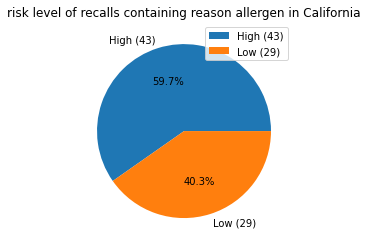

In [18]:
df_sub = augmented_df[recalls.states.str.contains("California", na=False)]
df_sub = df_sub[df_sub.reasons.str.contains("allergen", na=False)]
pie_q(df_sub, "risk level of recalls containing reason allergen in California")

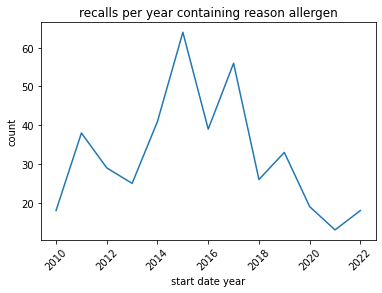

In [19]:
df_sub = augmented_df[augmented_df.reasons.str.contains("allergen", na=False)]
line_q(df_sub, "recalls per year containing reason allergen")

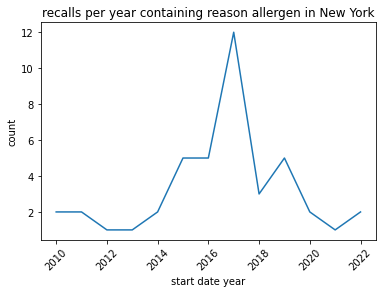

In [20]:
df_sub = augmented_df[recalls.states.str.contains("New York", na=False)]
df_sub = df_sub[df_sub.reasons.str.contains("allergen", na=False)]
line_q(df_sub, "recalls per year containing reason allergen in New York")

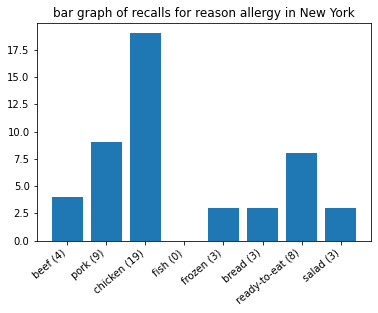

In [24]:
df_sub = augmented_df[recalls.states.str.contains("New York", na=False)]
df_sub = df_sub[df_sub.reasons.str.contains("allergen", na=False)]
bar_q(df_sub, "recalls for reason allergy in New York", qtype="r")

##Examples By Product

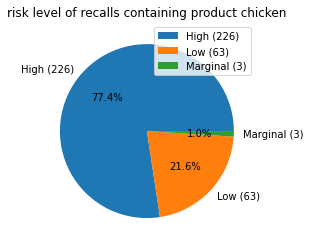

In [25]:
df_sub = augmented_df[augmented_df.products.str.contains("chicken", na=False)]
pie_q(df_sub, "risk level of recalls containing product chicken")

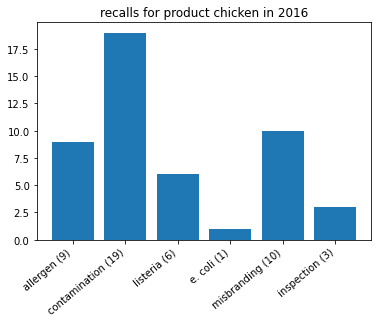

In [41]:
df_sub = augmented_df[augmented_df.products.str.contains("chicken", na=False)]
df_sub = df_sub[df_sub["start_date"].dt.year==2016]
bar_q(df_sub, "recalls for product chicken in 2016", qtype="p")

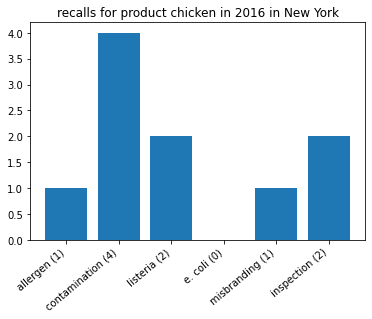

In [40]:
df_sub = augmented_df[recalls.states.str.contains("New York", na=False)]
df_sub = df_sub[df_sub.products.str.contains("chicken", na=False)]
df_sub = df_sub[df_sub["start_date"].dt.year==2016]
bar_q(df_sub, "recalls for product chicken in 2016 in New York", qtype="p")

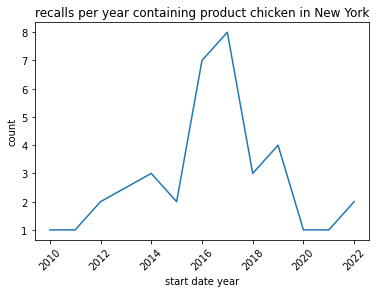

In [37]:
df_sub = augmented_df[recalls.states.str.contains("New York", na=False)]
df_sub = df_sub[df_sub.products.str.contains("chicken", na=False)]
line_q(df_sub, "recalls per year containing product chicken in New York")

In [88]:
df_sub = augmented_df[augmented_df.products.str.contains("chicken", na=False)]
df_sub = df_sub[df_sub["start_date"].dt.year==2016]
map_q(df_sub, "recalls per state containing product chicken in 2016")

#Interactive Tool

In [101]:
#INTERACTIVE QUERY AND VISUALIZATION

#please enter valid input only

state_q, year_q, products_q, reasons_q = "0", "0", "0", "0"

#query which visualization type
vis_type = int(input("""Please enter visualization type:
\n1 for pie chart of recall risks
\n2 for line chart of recalls per year (only available for all year selection)
\n3 for bar graph of recalls of product of common reasons
\n4 for bar graph of recalls of reason of common products
\n5 for choropleth map of recalls (only available for all states selection)
"""))

#query state
if vis_type != 5:
  state_q = input("Please enter state abbreviation (for example, CA or NY; or 0 for all states): ")
  state_q = states[state_q] if state_q != "0" else state_q

#query year
if vis_type != 2:
  year_q = input("Please enter year (in range 2010 to 2022; or 0 for all years): ")

#query product
if vis_type != 4:
  products_q = input("Please enter product query (for example, beef or salad; or 0 for all): ")

#query reason
if vis_type != 3:
  reasons_q = input("Please enter reason query (for example, allergen or listeria; or 0 for all): ")

df_sub = augmented_df.copy(deep=True)
#subset data based on text queries and
if state_q != "0":
  df_sub = df_sub[df_sub.states.str.contains(state_q, na=False)]

if year_q != "0":
  df_sub = df_sub[df_sub["start_date"].dt.year==int(year_q)]

if vis_type != 4 and products_q != "0":
  df_sub = df_sub[df_sub.products.str.contains(products_q, na=False)]

if vis_type != 3 and reasons_q != "0":
  df_sub = df_sub[df_sub.reasons.str.contains(reasons_q, na=False)]
#print(df_sub.size)


#construct title based on text queries
title = ""
title +=("states: " + state_q) if state_q != "0" else "states: ALL"
title +=("; years: " + year_q) if year_q != "0" else "; years: ALL"
title +=("; products: " + products_q) if products_q != "0" else "; products: ALL"
title +=("; reasons: " + reasons_q) if reasons_q != "0" else "; reasons: ALL"

#make visualization
if vis_type == 1:
  title = "risk level of recalls; "+title
  pie_q(df_sub, title)
if vis_type == 2:
  title = "recalls per year; "+title
  line_q(df_sub, title)
if vis_type == 3:
  title = "recalls of common reasons; "+title
  bar_q(df_sub, title, "p")
if vis_type == 4:
  title = "recalls of common products; "+title
  bar_q(df_sub, title, "r")
if vis_type == 5:
  title = "recalls per state; "+title
  map_q(df_sub, title)

Please enter visualization type:

1 for pie chart of recall risks

2 for line chart of recalls per year (only available for all year selection)

3 for bar graph of recalls of product of common reasons

4 for bar graph of recalls of reason of common products

5 for choropleth map of recalls (only available for all states selection)
5
Please enter year (in range 2010 to 2022; or 0 for all years): 2015
Please enter product query (for example, beef or salad; or 0 for all): 0
Please enter reason query (for example, allergen or listeria; or 0 for all): contamination
